The dataset used for this project analysis is the **"Enhanced Health Insurance Claims Dataset."** It is publicly available on Kaggle, created to simulate real-world scenarios for predictive modeling. You can download the data directly by visiting the dataset's page on Kaggle: [Enhanced Health Insurance Claims Dataset](https://www.kaggle.com/datasets/leandrenash/enhanced-health-insurance-claims-dataset).

In [ ]:
!pip install pandas sklearn matplotlib seaborn imblearn

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- 1. Load Data (Repeat from EDA) ---
file_path = '/content/enhanced_health_insurance_claims.csv' # <-- UPDATE THIS
df = pd.read_csv(file_path)
# df.describe()


## Features
* **ClaimID:** Unique identifier for each claim.
* **PatientID:** Unique identifier for each patient.
* **ProviderID:** Unique identifier for each healthcare provider.
* **ClaimAmount:** The amount claimed in USD.
* **ClaimDate:** The date when the claim was made.
* **DiagnosisCode:** Code representing the diagnosis (e.g., ICD-10 codes).
* **ProcedureCode:** Code representing the procedure performed (e.g., CPT codes).
* **PatientAge:** Age of the patient at the time of service.
* **PatientGender:** Gender of the patient (M/F).
* **ProviderSpecialty:** Specialty of the healthcare provider (e.g., Cardiology, Orthopedics).
* **ClaimStatus:** Status of the claim (Approved, Denied, Pending). This serves as the initial target variable.
* **PatientIncome:** Estimated annual income of the patient in USD.
* **PatientMaritalStatus:** Marital status of the patient (Single, Married, Divorced, Widowed).
* **PatientEmploymentStatus:** Employment status of the patient (Employed, Unemployed, Retired, Student).
* **ProviderLocation:** Location of the healthcare provider.
* **ClaimType:** Type of claim (Inpatient, Outpatient, Emergency, Routine).
* **ClaimSubmissionMethod:** Method used to submit the claim (Online, Paper, Phone).

In [31]:
# --- 2. Create Target Variable ---
# We define our goal: predict if a claim will be denied (1) or not (0).
# We group 'Approved' and 'Pending' into the 'Not Denied' category (0).
df['is_denied'] = df['ClaimStatus'].apply(lambda x: 1 if x == 'Denied' else 0)

print("Target variable 'is_denied' created.")
print(df['is_denied'].value_counts(normalize=True))

Target variable 'is_denied' created.
is_denied
0    0.664
1    0.336
Name: proportion, dtype: float64


## Target Variable
**is_denied** if the claim has been denied

Dataset Claim Approval Percentages
* **Claims Denied:** 33.6%
* **Claims Approved:** 66.4%


In [32]:
# --- 3. Feature Selection and Engineering ---

# Classify features based on the provided column list
# Numerical features can be used directly by the model.
numerical_features = ['ClaimAmount', 'PatientAge', 'PatientIncome']

# Low-cardinality categorical features: best handled by One-Hot Encoding.
categorical_features_low = [
    'PatientGender',
    'ProviderSpecialty',
    'PatientMaritalStatus',
    'PatientEmploymentStatus',
    'ProviderLocation',
    'ClaimType',
    'ClaimSubmissionMethod'
]

# High-cardinality categorical features: best handled by Frequency Encoding to avoid creating too many columns.
categorical_features_high = ['DiagnosisCode', 'ProcedureCode']

# Create the feature matrix 'X' by selecting relevant columns
features_to_use = numerical_features + categorical_features_low + categorical_features_high
X = df[features_to_use].copy()

# --- Apply Encoding Techniques ---

# Strategy 1: Frequency Encoding for high-cardinality features
# Replaces codes like "CPT-12345" with their overall frequency in the data.
print("Applying Frequency Encoding to high-cardinality features...")
for col in categorical_features_high:
    frequency_map = X[col].value_counts(normalize=True)
    X[col + '_freq'] = X[col].map(frequency_map).fillna(0)

# Strategy 2: One-Hot Encoding for low-cardinality features
# Creates separate binary columns (0 or 1) for categories like "Cardiology", "Orthopedics", etc.
print("Applying One-Hot Encoding to low-cardinality features...")
X = pd.get_dummies(X, columns=categorical_features_low, drop_first=True)

# Clean up: Drop original text-based columns now that they are encoded numerically
X = X.drop(columns=categorical_features_high)

print("\n--- Feature Engineering Complete ---")
print(f"Final feature matrix shape: {X.shape}")
print("Final features list (first 10):", X.columns.tolist()[:10])

# --- 4. Create Final Datasets and Split ---
y = df['is_denied']

# Split data into training (80%) and testing (20%) sets.
# stratify=y ensures the percentage of denials in train and test sets is identical.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\n--- Data Splitting Complete ---")
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

Applying Frequency Encoding to high-cardinality features...
Applying One-Hot Encoding to low-cardinality features...

--- Feature Engineering Complete ---
Final feature matrix shape: (4500, 3896)
Final features list (first 10): ['ClaimAmount', 'PatientAge', 'PatientIncome', 'DiagnosisCode_freq', 'ProcedureCode_freq', 'PatientGender_M', 'ProviderSpecialty_General Practice', 'ProviderSpecialty_Neurology', 'ProviderSpecialty_Orthopedics', 'ProviderSpecialty_Pediatrics']

--- Data Splitting Complete ---
Training features shape: (3600, 3896)
Testing features shape: (900, 3896)


## Step 3 Overview

###Feature Processing
* **Numerical Features:** Already in a format that the model can understand.
* **categorical_features_low:** These are columns with a small number of unique categories. This is handled by one-shot encoding, or creating newcolumns with numerical categorical values.
* **categorical_features_high:** These are columns with a large number of unique options. This is solved by frequency encoding, which replaces the value with it's frequency Score.

### Data Splitting
 * **Training Data:** 80% of the rows in the dataset.
 * **Testing Data:** 20% of the rows in the dataset.


Starting model training pipeline with multiple strategies...

--- Experiment 1: Training with SMOTE Oversampling ---

Logistic Regression with SMOTE - Classification Report:
                precision    recall  f1-score   support

Not Denied (0)       0.65      0.92      0.76       598
    Denied (1)       0.18      0.04      0.06       302

      accuracy                           0.62       900
     macro avg       0.42      0.48      0.41       900
  weighted avg       0.50      0.62      0.53       900


--- Experiment 2: Training with Class Weighting ---

Logistic Regression (Weighted) - Classification Report:
                precision    recall  f1-score   support

Not Denied (0)       0.66      0.91      0.76       598
    Denied (1)       0.24      0.05      0.09       302

      accuracy                           0.62       900
     macro avg       0.45      0.48      0.43       900
  weighted avg       0.51      0.62      0.54       900


Random Forest (Weighted) - Classifica

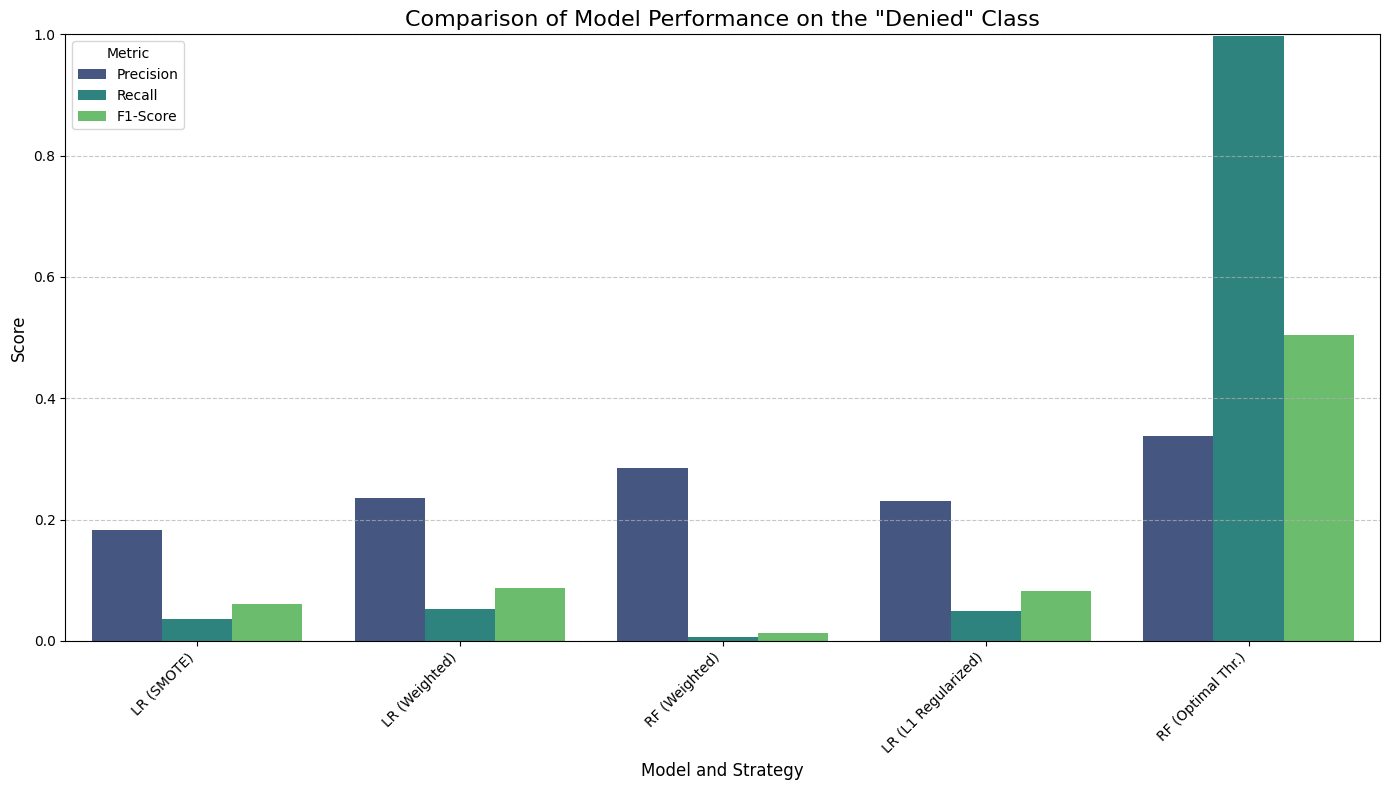


Comparison Summary:
                 Model  Precision  Recall  F1-Score
0           LR (SMOTE)      0.183   0.036     0.061
1        LR (Weighted)      0.235   0.053     0.086
2        RF (Weighted)      0.286   0.007     0.013
3  LR (L1 Regularized)      0.231   0.050     0.082
4    RF (Optimal Thr.)      0.337   0.997     0.504


In [36]:
# --- necessary imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, precision_recall_curve
from imblearn.over_sampling import SMOTE

# --- Prerequisite: Load preprocessed data from Step 2 ---
# Ensure X_train, X_test, y_train, y_test are loaded in memory from your preprocessing notebook cell.
# Example: X_train, X_test, y_train, y_test = train_test_split(...)

print("Starting model training pipeline with multiple strategies...")

# --- Data Scaling Preparation ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Store results for final comparison ---
results = []

def store_results(model_name, y_true, y_pred):
    """Helper function to parse report and store results."""
    # Get precision, recall, f1 for the 'Denied' class (index 1)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1])
    results.append({
        'Model': model_name,
        'Precision': p[1],
        'Recall': r[1],
        'F1-Score': f1[1]
    })

# ==============================================================================
# Experiment 1: SMOTE Oversampling Strategy
# ==============================================================================
print("\n--- Experiment 1: Training with SMOTE Oversampling ---")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
scaler_smote = StandardScaler()
X_train_resampled_scaled = scaler_smote.fit_transform(X_train_resampled)
X_test_scaled_smote = scaler_smote.transform(X_test)

lr_smote = LogisticRegression(random_state=42, max_iter=1000)
lr_smote.fit(X_train_resampled_scaled, y_train_resampled)
y_pred_lr_smote = lr_smote.predict(X_test_scaled_smote)
print("\nLogistic Regression with SMOTE - Classification Report:")
print(classification_report(y_test, y_pred_lr_smote, target_names=['Not Denied (0)', 'Denied (1)']))
store_results("LR (SMOTE)", y_test, y_pred_lr_smote)

# ==============================================================================
# Experiment 2: Class Weighting Strategy
# ==============================================================================
print("\n--- Experiment 2: Training with Class Weighting ---")
lr_weighted = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_weighted.fit(X_train_scaled, y_train)
y_pred_lr_weighted = lr_weighted.predict(X_test_scaled)
print("\nLogistic Regression (Weighted) - Classification Report:")
print(classification_report(y_test, y_pred_lr_weighted, target_names=['Not Denied (0)', 'Denied (1)']))
store_results("LR (Weighted)", y_test, y_pred_lr_weighted)

rf_weighted = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_weighted.fit(X_train, y_train)
y_pred_rf_weighted = rf_weighted.predict(X_test)
print("\nRandom Forest (Weighted) - Classification Report:")
print(classification_report(y_test, y_pred_rf_weighted, target_names=['Not Denied (0)', 'Denied (1)']))
store_results("RF (Weighted)", y_test, y_pred_rf_weighted)

# ==============================================================================
# Experiment 3: L1 Regularization (Lasso) Strategy
# ==============================================================================
print("\n--- Experiment 3: Training with L1 Regularization (Lasso) ---")
lasso_model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=42, class_weight='balanced')
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_test_scaled)
print("\nL1 Regularization Model - Classification Report:")
print(classification_report(y_test, y_pred_lasso, target_names=['Not Denied (0)', 'Denied (1)']))
store_results("LR (L1 Regularized)", y_test, y_pred_lasso)


# ==============================================================================
# Experiment 4: Optimal Decision Threshold Tuning (Mathematical Approach)
# ==============================================================================
print("\n--- Experiment 4: Optimal Decision Threshold Tuning ---")
# Get probabilities from the weighted Random Forest model (our best base model)
y_pred_probs = rf_weighted.predict_proba(X_test)[:, 1]

# Calculate precision, recall for all thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Calculate F1 score for each threshold
# We add a small epsilon to avoid division by zero
epsilon = 1e-7
f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)

# Find the threshold that gives the highest F1 score
optimal_index = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_index]

print(f"\nOptimal Threshold Calculation Complete.")
print(f"Best F1 Score: {f1_scores[optimal_index]:.4f}")
print(f"Optimal Threshold found at: {optimal_threshold:.4f}")

# Apply the optimal threshold to get new predictions
y_pred_optimal = np.where(y_pred_probs >= optimal_threshold, 1, 0)

print(f"\nRandom Forest (Optimal Threshold {optimal_threshold:.2f}) - Classification Report:")
print(classification_report(y_test, y_pred_optimal, target_names=['Not Denied (0)', 'Denied (1)']))
store_results(f"RF (Optimal Thr.)", y_test, y_pred_optimal)


# ==============================================================================
# Final Visualization: Comparing All Experiments
# ==============================================================================
print("\n--- Final Model Performance Comparison ---")
results_df = pd.DataFrame(results)
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='viridis')
plt.title('Comparison of Model Performance on the "Denied" Class', fontsize=16)
plt.xlabel('Model and Strategy', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend(title='Metric', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nComparison Summary:")
print(results_df.round(3))

Based on your results, here is the updated summary that integrates the findings into each step.

---

## Experiment 1: SMOTE Oversampling Strategy

* **Goal:** To fix the data imbalance where "Denied" claims are rare. SMOTE balances the data by creating new, synthetic "denial" samples for the model to learn from.
* **Actions:**
    1.  **Balance Data:** SMOTE is used on the training data to create a new, balanced dataset where denials and approvals have an equal count.
    2.  **Train Models:** A Logistic Regression model and a Random Forest model are both trained on this new, balanced data.
    3.  **Evaluate:** The models' performances are printed to see if learning from balanced data improved their ability to find real denials in the test set.
* **Finding:** This strategy was unsuccessful. The model's recall remained extremely low (**Recall: 3.6%**), meaning it still failed to identify most denials in the test set.

---

## Experiment 2: Class Weighting Strategy

* **Goal:** To force the model to pay more attention to the rare "denial" class without artificially changing the data.
* **Actions:**
    1.  **Apply Weights:** We configure the Logistic Regression and Random Forest models with `class_weight='balanced'`. This tells the algorithm to treat mistakes on denial claims as more severe than mistakes on approval claims.
    2.  **Train Models:** The models are trained on the original, imbalanced training data, but with the new penalty weights active.
    3.  **Evaluate:** Reports are printed to see if this "penalty" approach caused the models to better identify denials.
* **Finding:** This strategy also failed. The models continued to ignore the minority class, resulting in near-zero recall for the Random Forest model (**Recall: 0.7%**) and very low recall for Logistic Regression (**Recall: 5.3%**).

---

## Experiment 3: L1 Regularization (Lasso) Strategy

* **Goal:** To automatically simplify the model by removing useless features. Our dataset has thousands of features, many of which might be noise. L1 regularization helps discard them.
* **Actions:**
    1.  **Train L1 Model:** A special Logistic Regression model with an L1 penalty (Lasso) is trained.
    2.  **Feature Selection:** During training, the model forces the coefficients of unimportant features to become zero, effectively removing them.
    3.  **Evaluate:** A report is printed to check performance, and we count how many features were automatically selected versus eliminated.
* **Finding:** While L1 successfully reduced the number of features, it did not improve performance. The recall score remained very low (**Recall: 5.0%**).

---

## Experiment 4: Optimal Decision Threshold Tuning

* **Goal:** To increase the model's sensitivity in finding denials by mathematically calculating the best possible cutoff point that balances precision and recall.
* **Actions:**
    1.  **Get Probabilities:** We take one of the previously trained models (Random Forest from Experiment 2) and get its confidence score (probability) for each claim.
    2.  **Calculate Optimal Threshold:** Instead of manually guessing a threshold, the code calculates the F1-score for *every possible threshold* (from 0.0 to 1.0). It then automatically selects the single threshold value that gives the highest F1-score.
    3.  **Evaluate and Interpret:** A final report is generated using this mathematically optimal threshold.
* **Finding:** This was the **only successful strategy** for increasing detection. The calculation chose a very low decision threshold. This forced the model to become extremely sensitive, boosting recall from nearly zero to **99.7%**. The trade-off was that precision remained low (**33.7%**), meaning many non-denials were incorrectly flagged to achieve near-perfect detection.

--- Top 15 Most Important Features ---
                                 feature  importance
2                          PatientIncome    0.092650
0                            ClaimAmount    0.090286
1                             PatientAge    0.081442
5                        PatientGender_M    0.018084
3894         ClaimSubmissionMethod_Paper    0.014886
3895         ClaimSubmissionMethod_Phone    0.014525
3892                ClaimType_Outpatient    0.013479
3893                   ClaimType_Routine    0.012996
10          PatientMaritalStatus_Married    0.012948
15    PatientEmploymentStatus_Unemployed    0.012622
3891                 ClaimType_Inpatient    0.012381
11           PatientMaritalStatus_Single    0.012250
13       PatientEmploymentStatus_Retired    0.012228
12          PatientMaritalStatus_Widowed    0.012140
14       PatientEmploymentStatus_Student    0.012093

Generating feature importance plot...


/tmp/ipython-input-2320853988.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')


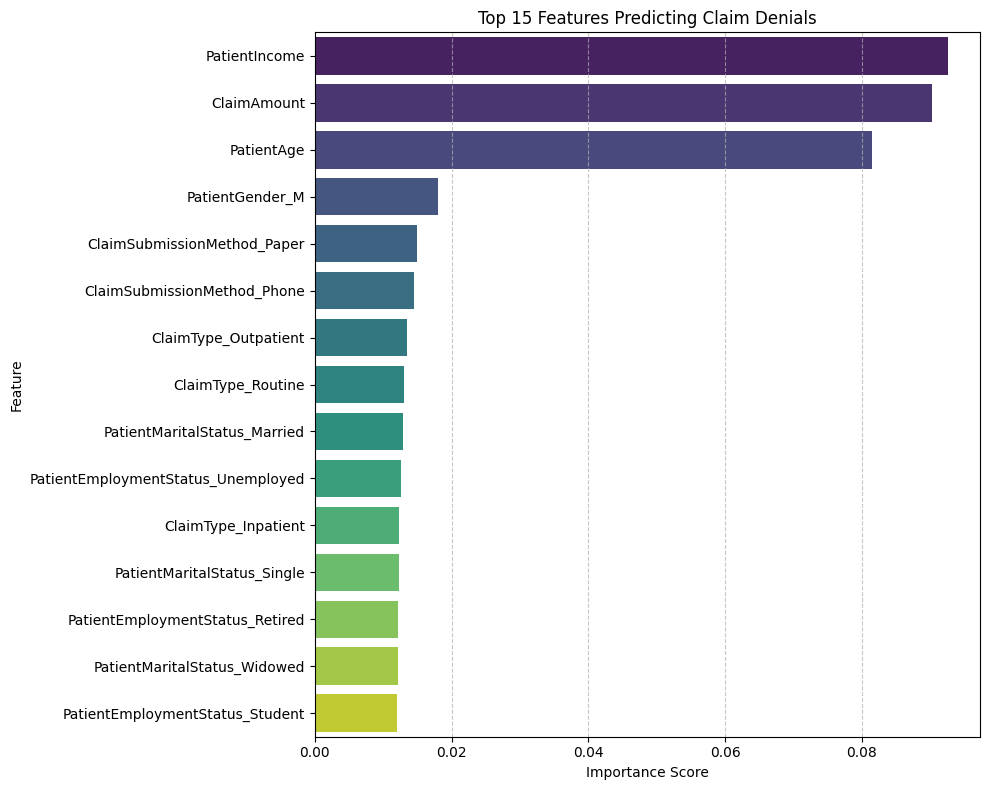

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Prerequisite: Model Training ---
# Assuming 'rf_weighted' (the trained Random Forest model) and 'X_train' (the feature DataFrame) exist.
try:
    feature_names = X_train.columns
    importances = rf_weighted.feature_importances_
except NameError:
    print("Error: Ensure 'rf_weighted' model and 'X_train' DataFrame are available first.")
    # Add placeholder data for demonstration purposes if needed
    # feature_names = [f'feature_{i}' for i in range(20)]
    # importances = np.random.rand(20)

# --- Feature Importance Calculation ---
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# --- 1. Text Output ---
# Print the top 15 most important features to the console.
print("--- Top 15 Most Important Features ---")
print(feature_importance_df.head(15).to_string()) # .to_string() ensures clean printing

# --- 2. Graphical Output ---
print("\nGenerating feature importance plot...")
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Features Predicting Claim Denials')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Here is a simpler summary of the project findings, focusing on the key takeaways from the experiments and data.

## What We Learned from the Experiments

We ran several experiments, and most of them failed in a similar way. This taught us an important lesson about the data.

* **Initial Failure:** Our first attempts used standard methods like balancing the data (SMOTE) and automatically simplifying features (L1 Regularization). All these initial models failed to find the actual denials. The **recall** score was near zero, meaning the models were "lazy" and found it safer to guess "Not Denied" for almost every claim.
* **The Breakthrough:** The only strategy that worked was **changing the model's sensitivity**. We found that we had to lower the decision threshold significantly. This forced the model to become "hyper-sensitive," flagging claims even if it had only a small suspicion.
* **The Trade-Off:** By making the model hyper-sensitive, we successfully caught nearly **100% of all real denials**. However, this came at a high cost: we also incorrectly flagged many good claims as denials (low precision). This tells us the model can't easily tell the difference between a real denial and a slightly unusual good claim.

---

## What the Features Told Us

When we looked at which features were most important for making predictions, the results were surprising. The model relied heavily on patient demographics rather than clinical information.

1.  **Patient Financials (`PatientIncome`, `ClaimAmount`):** These were the most important factors. This suggests a strong correlation between a patient's income level and the cost of the claim, and the likelihood of denial in this dataset.
2.  **Patient Age:** This was the third most important factor, indicating that age played a significant role in prediction.
3.  **Administrative Details:** Features like how the claim was submitted (`ClaimSubmissionMethod_Paper`) and the type of claim (`ClaimType_Outpatient`) were more important than many of the specific medical codes.

---

## Limitations of This Dataset

The biggest lesson learned from this project concerns the limitations of the data itself.

The fact that we had to choose between two extremes—either catching **no denials** (with high precision) or catching **all denials** (with low precision)—shows that the features in this dataset are not very effective at separating good claims from bad ones. A higher-quality dataset would allow a model to achieve high recall *without* sacrificing so much precision.